# 3rd Assignment - Adaptive Control Systems Design - MRAC

In [1]:
from scipy.integrate import odeint as ode
from scipy.linalg import solve_lyapunov
import numpy as np
from numpy.linalg import norm
from numpy.linalg import multi_dot
import matplotlib.pyplot as plt

##  Reference Model

### Model Parameters

In [2]:
Am = np.array([[ 0 ,  1 ],
               [-24, -10]])
Bm = np.array([[0],
               [24]])

theta_c = lambda t: 5 * (np.pi/180) * (t//3)

### Actual model

In [3]:
def ref_model(x, t):
    x = x.reshape((len(x),-1))
    dxdt = Am.dot(x) + Bm.dot(theta_c(t))

    return dxdt.squeeze()

### Simulate and plot results

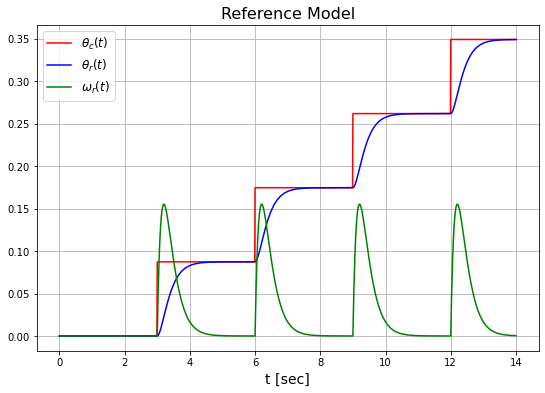

In [4]:
t         = np.linspace(0, 14, 1401) # initialize time
x0        = [0, 0] # initial condition
x_ref     = ode(ref_model, x0, t) # simulate model

plt.figure(figsize=(9, 6))
plt.plot(t, theta_c(t) , 'r', label=r'$\theta_c(t)$')
plt.plot(t, x_ref[:, 0], 'b', label=r'$\theta_r(t)$')
plt.plot(t, x_ref[:, 1], 'g', label=r'$\omega_r(t)$')
plt.legend(loc='best', prop={'size': 12})
plt.xlabel('t [sec]', fontsize=14)
plt.grid()
plt.title('Reference Model', fontsize=16)
plt.show()

## Model with Uncertainty
### Model parameters

In [5]:
J   = 4.5 * 10**(-5) # [kgr*M^2] moment of inertia
K_m = 0.19           # [N*m/A] motor torque constant
B   = 8   * 10**(-4) # [N*M*sec/rad] friction coefficient
N   = 50             # notches

# true model
A   = np.array([[0, 1   ],
                [0, -B/J]])
BL  = np.array([[0    ],
                [K_m/J]])

# matching conditions
Am_A = Am - A
Kx_ideal = np.squeeze(np.array([[Am_A[1, 0]/BL[1]], [Am_A[1, 1]/BL[1]]])) # A + BL.dot(Kx.T) = Am
Kr_ideal = np.squeeze(Bm[1]/BL[1])                                        # BL.dot(Kr.T) = Bm

### User selectable parameters

In [6]:
value = 8*10**(-3)
Gamma_x = np.eye(2)*value # Kx update step
Gamma_r = value           # Kr update step

Q = np.eye(2) * 10**(-1)
P = solve_lyapunov(Am.T, -Q)
print(P)

[[0.14583333 0.00208333]
 [0.00208333 0.00520833]]


### Augmented model
Augmented model includes true model (with uncertainty), reference model, error, Kx and Kr

In [7]:
def aug_model(y, t):
    x  = y[0:2].reshape((2,-1))
    xm = y[2:4].reshape((2,-1))
    e  = y[4:6].reshape((2,-1))
    Kx = y[6:8].reshape((2,-1))
    Kr = y[8  ]

    u       = Kx.T.dot(x) + Kr*theta_c(t)

    dydt = [np.squeeze( A.dot(x)  + BL*u), # true model
            np.squeeze(Am.dot(xm) + Bm.dot(theta_c(t))), # reference model
            np.squeeze(Am.dot(e)  + (A + BL.dot(Kx.T) - Am).dot(x) + (BL*Kr - Bm).dot(theta_c(t))), # error
            np.squeeze(-multi_dot([Gamma_x, x, e.T, P, BL])), # Kx
            np.squeeze(-Gamma_r * theta_c(t) * multi_dot([e.T, P, BL])) # Kr
           ]

    return np.hstack(dydt)

### Function to plot results

In [8]:
def plot_results(y, t, a, title=None):
    fig, (theta, omega) = plt.subplots(1, 2, figsize=(15, 7))

    theta.plot(t, y[:, 0], 'r', label=r'$\theta(t)$')
    theta.plot(t, y[:, 2], 'b', label=r'$\theta_{ref}(t)$')
    theta.legend(loc='best', prop={'size': 13})
    theta.set_xlabel('t [sec]', fontsize=14)
    theta.set_ylabel(r'$\theta$ [rad]', fontsize=14)
    theta.grid()
    theta.set_title(r'Angular Position $\theta$', fontsize=16)

    omega.plot(t, y[:, 1], color = 'm', label=r'$\omega(t)$')
    omega.plot(t, y[:, 3], color = 'c', label=r'$\omega_{ref}(t)$')
    omega.legend(loc='best', prop={'size': 13})
    omega.set_xlabel('t [sec]', fontsize=14)
    omega.set_ylabel(r'$\omega$ [rad/sec]', fontsize=14)
    omega.grid()
    omega.set_title(r'Angular Speed  $\omega$', fontsize=16)

    if title is None:
        title = f"Uncertainty = {a*100}%"

    fig.suptitle(title, fontsize=18)
    plt.show()

### Simulate and plot results for various values of uncertainty

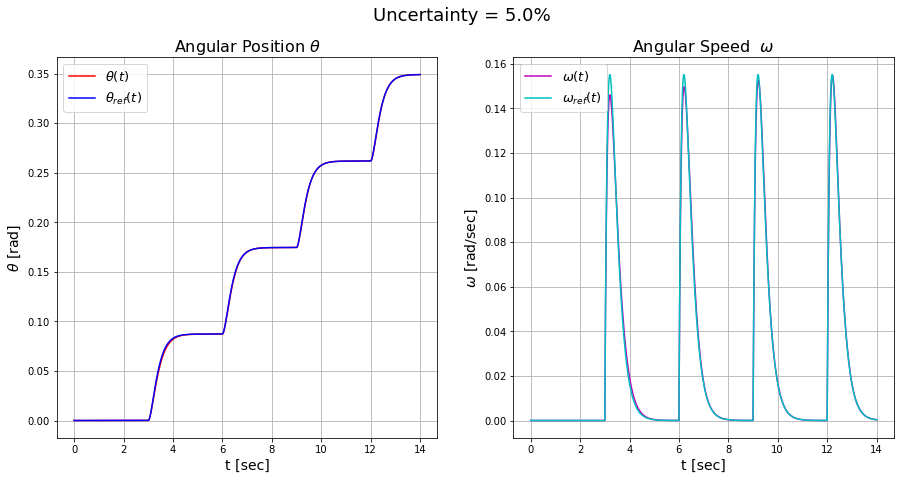

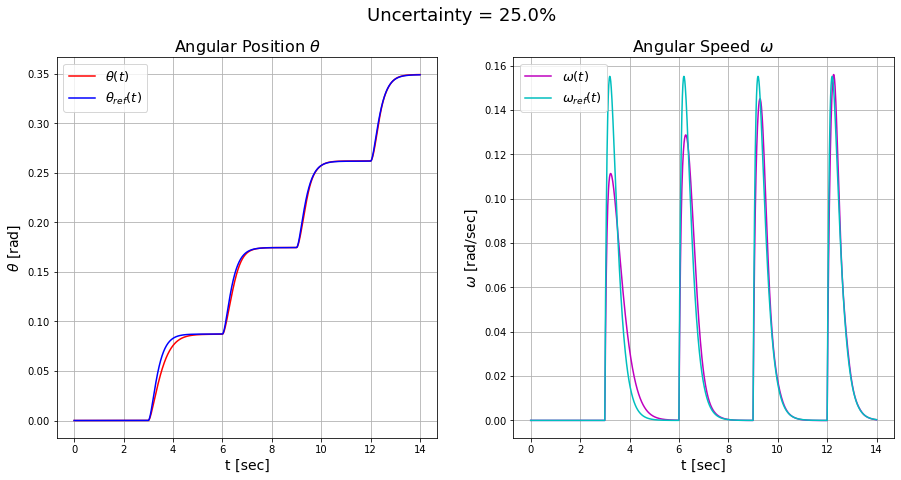

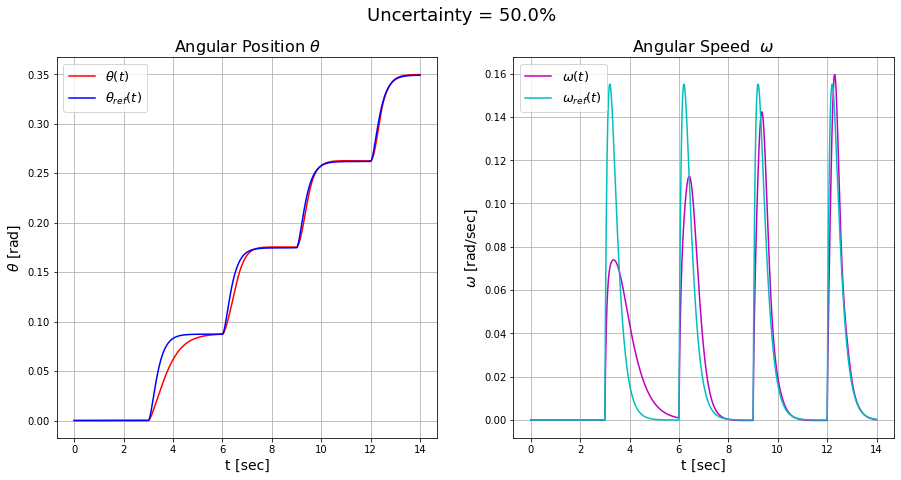

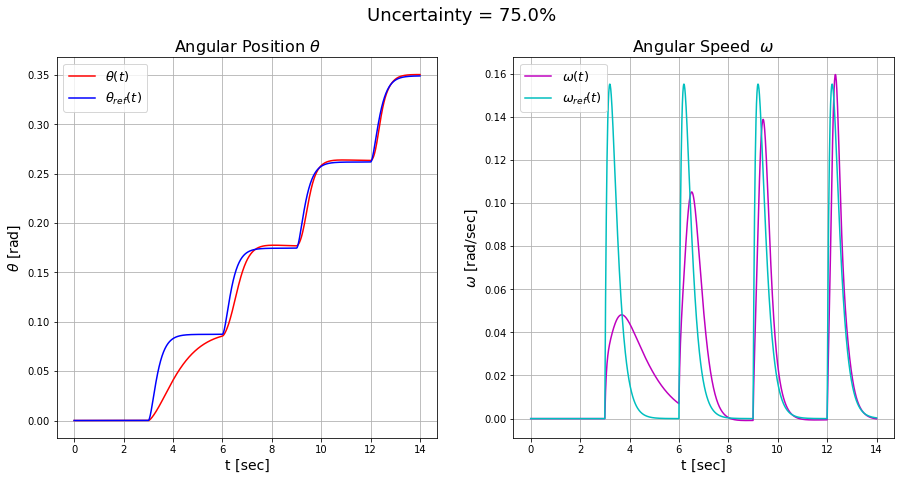

In [9]:
a = [0.05, 0.25 , 0.5, 0.75] # uncertainty

for a_c in a:
    Kx_in = (1-a_c)*Kx_ideal
    Kr_in = (1-a_c)*Kr_ideal

    # initial condition
    y0 = np.array([0, 0, # theta, omega -> true model
                   0, 0, # theta, omega -> reference model
                   0, 0, # theta, omega -> error
                   Kx_in[0], Kx_in[1], # Kx
                   Kr_in # Kr
                  ])

    # simulate model
    y  = ode(aug_model, y0, t)

    # plot results
    plot_results(y, t, a_c)

## Model with Uncertainty and Unknown Torque Load

### User selectable parameters

In [10]:
k = 5 # number of RBFs to use to approximate the unknown torque load

value    = 8*10**(-3)
Gamma_x  = np.eye(2)*value    # Kx    update step
Gamma_r  = value              # Kr    update step
Gamma_th = np.eye(k)*value*10 # Theta update step

s_x  = 0 # Kx    damping parameter
s_r  = 0 # Kr    damping parameter
s_th = 0 # Theta damping parameter

### RBF network
#### RBF kernel function

In [11]:
def rbf(x, center, sigma):
    return np.exp(- (x - center)**2 / (2 * sigma**2))

#### RBF network parameters calculation

In [12]:
centers = np.linspace(0, np.pi, k+1, endpoint=True)[1:] - 1/(2*k)
stds    = np.repeat(np.std(np.linspace(0, 2*centers[0], 10000001, endpoint=True)), k)
Phi     = lambda x: np.array([rbf(x % np.pi, c, s) for c, s in zip(centers, stds)]).reshape((k, -1))

### Augmented model including the uknown torque load
Augmented model includes true model (with uncertainty), reference model, error, Kx, Kr and Theta
#### Applied torque load (unknown to the system)

In [13]:
f = lambda x: 10**(-3) * (np.cos(2*x))**2 * np.sin(3*x) / K_m

#### Actual model

In [14]:
def aug_model_torque(y, t):
    x     = y[0:2].reshape((2,-1))
    xm    = y[2:4].reshape((2,-1))
    e     = y[4:6].reshape((2,-1))
    Kx    = y[6:8].reshape((2,-1))
    Kr    = y[8  ]
    Theta = y[9: ].reshape((k, -1))

    u       = Kx.T.dot(x) + Kr*theta_c(t) + Theta.T.dot(Phi(x[0][0]))
    eT_P_BL = multi_dot([e.T, P, BL])

    dydt = [np.squeeze( A.dot(x)  + BL*(u-f(x[0][0]))), # true model
            np.squeeze(Am.dot(xm) + Bm.dot(theta_c(t))), # reference model
            np.squeeze(Am.dot(e)  + (A + BL.dot(Kx.T) - Am).dot(x) \
                                  + (BL*Kr - Bm).dot(theta_c(t)) \
                                  + BL * (Theta.T.dot(Phi(x[0][0]))-f(x[0][0]))), # error
            np.squeeze(-Gamma_x.dot( x.dot(eT_P_BL)            + s_x *norm(eT_P_BL)*Kx   )), # Kx
            np.squeeze(-Gamma_r *   (theta_c(t) * eT_P_BL      + s_r *norm(eT_P_BL)*Kr   )), # Kr
            np.squeeze(-Gamma_th.dot(Phi(x[0][0]).dot(eT_P_BL) + s_th*norm(eT_P_BL)*Theta))  # Theta
           ]

    return np.hstack(dydt)

### Simulate and plot results

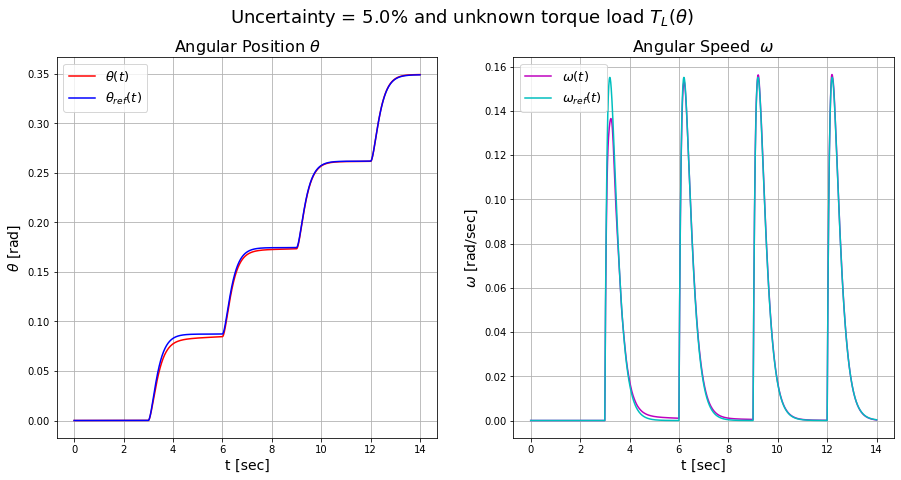

In [15]:
a = 0.05 # uncertainty
Kx_in    = (1-a)*Kx_ideal
Kr_in    = (1-a)*Kr_ideal
Theta_in = np.zeros(k)

# initial conditions
y0 = np.array([0, 0, # theta, omega -> true model
               0, 0, # theta, omega -> reference model
               0, 0, # theta, omega -> error
               Kx_in[0], Kx_in[1], # Kx
               Kr_in # Kr
              ]+list(Theta_in) # Theta
             )

# simulate model
y  = ode(aug_model_torque, y0, t)

# plot results
plot_results(y, t, a, fr"Uncertainty = {a*100}% and unknown torque load $T_L(\theta)$")

#### Epsilon modification
Although there is not a problem with the Adaptive Parameters Bounds, we still implemented and test an epsion modification for the update rules to keep them bounded no matter what

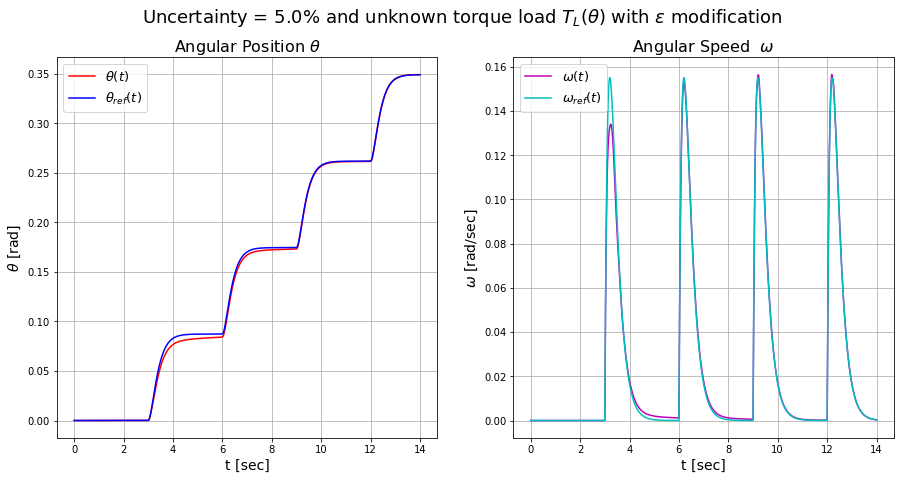

In [16]:
s_x  = 20 # Kx    damping parameter
s_r  = 20 # Kr    damping parameter
s_th = 20 # Theta damping parameter

# simulate model
y  = ode(aug_model_torque, y0, t)

# plot results
plot_results(y, t, a, fr"Uncertainty = {a*100}% and unknown torque load $T_L(\theta)$ with $\epsilon$ modification")